### Title: Day-Ahead Solar GHI Forecasting Using Machine Learning with XGBoost

#####  Candidate Name: Tanya Sharan       
##### Email ID: tanyasharan@yahoo.com

#### Ojective: The goal of this project is to develop a robust AI/ML model that forecasts day-ahead Global Horizontal Irradiance (GHI) using historical environmental data. The model is evaluated on the Mean Absolute Percentage Error (MAPE), with particular care taken for cases where actual GHI is zero. In addition to overall accuracy, a month-wise MAPE summary is also computed as required.

##### Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Zelestra Assignment"

'Test Dataset.csv'  'Train Dataset.csv'


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Zelestra Assignment/Train Dataset.csv")
original_train_data = train_data.copy()

test_data = pd.read_csv("/content/drive/MyDrive/Zelestra Assignment/Test Dataset.csv")
original_test_data = test_data.copy()

In [ ]:
train_data['DateTime'] = pd.to_datetime(train_data['timestamp'])
train_data.set_index('DateTime', inplace=True)

test_data['DateTime'] = pd.to_datetime(test_data['timestamp'])
test_data.set_index('DateTime', inplace=True)

In [ ]:
train_data.columns

Index(['Unnamed: 0', 'timestamp', 'irradiance_global_reference',
       'irradiance_horizontal', 'module_temperature_1', 'module_temperature_2',
       'module_temperature_3', 'wind_direction', 'relative_humidity',
       'horizontal_radiation_1', 'horizontal_radiation_2',
       'horizontal_radiation_3', 'incident_radiation_1',
       'incident_radiation_2', 'incident_radiation_4', 'incident_radiation_3',
       'reflected_radiation_1', 'reflected_radiation_2',
       'reflected_radiation_4', 'reflected_radiation_3', 'ambient_temperature',
       'wind_speed', 'ghi'],
      dtype='object')

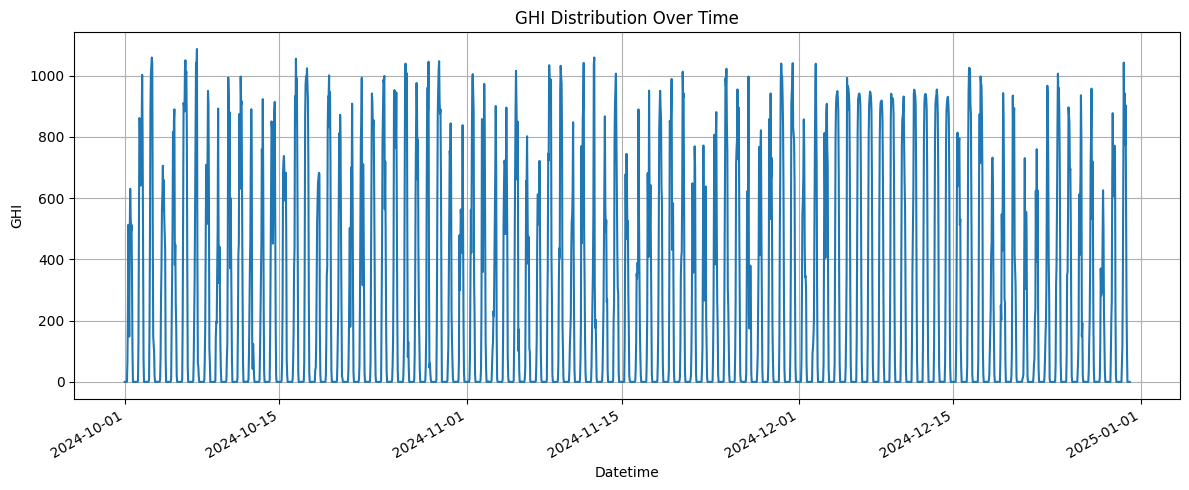

In [ ]:
# Plot GHI Distribution Over Time
plt.figure(figsize=(12, 5))
train_data['ghi'].plot()
plt.title('GHI Distribution Over Time')
plt.xlabel('Datetime')
plt.ylabel('GHI')
plt.grid(True)
plt.tight_layout()
plt.show()

##### This time series plot shows how Global Horizontal Irradiance (GHI) varies throughout the training period. Sharp peaks represent daytime solar radiation, while flat regions indicate nighttime hours when GHI is near zero.

#### Data Preprocessing: The following preprocessing steps were applied to prepare the raw training and test datasets for modeling

##### 1. Drop Irrelevant Columns
###### - Removed (Unnamed: 0), redundant index column from CSV.
###### - Dropped (timestamp) datetime was already converted and used to extract features (like hour).

##### 2. Remove Columns with High Missingness
###### - Dropped columns with ≥30% missing values to avoid unreliable imputations and reduce noise.

##### 3. Encode Wind Direction as Circular
###### - Transformed wind_direction using cos(θ) + sin(θ). This preserves the cyclical nature of directional data (e.g., 0° ≈ 360°)

##### 4. Filter Rows with Missing Target
###### - Rows with missing GHI values were dropped since the target variable must be present for supervised learning.

##### 5. Remove GHI Outliers
###### - Removed the top 1% of GHI values to reduce extreme outliers and stabilize model learning.

##### 6. Apply Exponential Moving Average (EMA)
###### - Smoothed all numeric features (except hour) using EMA with "span=24". Helps reduce noise and emphasize recent trends in weather conditions.

##### 7. Log Transformation of GHI
###### - Applied log1p to the GHI values to normalise skewed distribution, stabilise variance and improve regression model performance.

##### 8. Extract Time-Based Feature
###### - Extracted hour from the datetime index to capture daily solar patterns.
###### - Reset index after extraction.

##### 9. Impute Missing Values (KNN)
###### - Applied KNN imputation (n_neighbors=5) to fill any remaining missing values based on feature similarity.





In [ ]:
def preprocessing(df):
    import pandas as pd
    import numpy as np
    from sklearn.impute import KNNImputer

    # Drop 'Unnamed: 0' and 'timestamp' if present
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')
    df = df.drop(columns=['timestamp'], errors='ignore')

    # Drop columns with ≥30% missing values
    missing_fraction = df.isnull().mean()
    cols_to_drop = missing_fraction[missing_fraction >= 0.3].index
    df = df.drop(columns=cols_to_drop)

    # Encode wind direction as circular
    df['wind_direction'] = np.cos(np.deg2rad(df['wind_direction'])) + np.sin(np.deg2rad(df['wind_direction']))

    # Drop rows with missing GHI
    df = df[df['ghi'].notnull()]

    # Remove top 1% GHI outliers
    ghi_threshold = df['ghi'].quantile(0.99)
    df = df[df['ghi'] <= ghi_threshold].copy()

    # Apply EMA in-place
    for col in df.columns:
        if col != 'hour' and np.issubdtype(df[col].dtype, np.number):
            df[col] = df[col].ewm(span=24, adjust=False).mean()

    # Apply log1p to smoothed GHI
    df['ghi'] = np.log1p(df['ghi'])

    # Drop index (DateTime) and extract hour feature
    if isinstance(df.index, pd.DatetimeIndex):
        df['hour'] = df.index.hour
        # Drop DateTime index
        df = df.reset_index(drop=True)

    # Impute missing values using KNN
    if df.isnull().values.any():
        imputer = KNNImputer(n_neighbors=5)
        df[:] = imputer.fit_transform(df)

    return df

In [ ]:
train_data = preprocessing(train_data)

In [ ]:
test_data = preprocessing(test_data)

In [ ]:
train_data.columns

Index(['irradiance_global_reference', 'irradiance_horizontal',
       'module_temperature_1', 'module_temperature_2', 'module_temperature_3',
       'wind_direction', 'relative_humidity', 'horizontal_radiation_1',
       'incident_radiation_1', 'incident_radiation_4', 'reflected_radiation_1',
       'reflected_radiation_4', 'ambient_temperature', 'wind_speed', 'ghi',
       'hour'],
      dtype='object')

In [ ]:
set(train_data.columns) == set(test_data.columns)

False

In [ ]:
common_cols = train_data.columns.intersection(test_data.columns)
train_data = train_data[common_cols]
test_data = test_data[common_cols]

#### Model Training & Prediction Approach (XGBoost): The following approach was used to build a robust day-ahead GHI prediction model using XGBoost Regressor

##### 1. Feature & Target Separation
###### - Split the dataset into X_train / X_test (features excluding ghi) and y_train / y_test (log-transformed target ghi).

##### 2. Model Selection
###### - Initialized an XGBRegressor model with parameters (n_estimators=100), (learning_rate=0.1), (max_depth=5), and (random_state=42).

##### 3. Training
###### - The model was trained on the preprocessed and log-transformed GHI data (log1p(ghi)).

##### 4. Prediction & Inverse Transformation
##### - Predicted GHI values (y_pred_log) on the test set.
##### - Applied inverse log transformation using np.expm1() to get actual GHI values (y_pred and y_actual).

##### 5. Postprocessing Rule
###### - Set Predicted_GHI = 0 for samples with irradiance_global_reference < 5
###### - This prevents unrealistic predictions during early morning or late evening hours with negligible solar radiation.

##### 6. Result Visualization
###### - Plotted the first 100 predictions against actual GHI to visually inspect model accuracy and trend alignment.

In [ ]:
def train_and_predict_xgboost(train_data, test_data):
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_absolute_percentage_error
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Separate features and target
    X_train = train_data.drop(columns=['ghi'])
    y_train = train_data['ghi']

    X_test = test_data.drop(columns=['ghi'])
    y_test = test_data['ghi']

    # Train model

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

    model.fit(X_train, y_train)

    # Predict on test set
    y_pred_log = model.predict(X_test)

    # Reverse log1p transformation
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y_test)

    # Prepare results DataFrame
    results = pd.DataFrame({
        'Predicted_GHI': y_pred,
        'Actual_GHI': y_actual.values
    }, index=X_test.index)

    # Postprocess: Set predicted GHI to 0 where irradiance is low (irradiance_global_reference < 5)
    if 'irradiance_global_reference' in X_test.columns:
        irr = X_test.loc[results.index, 'irradiance_global_reference']
        results.loc[irr < 5, 'Predicted_GHI'] = 0

    # Print head
    print(results.head(200))

    # Plot predictions against actual GHI
    plt.figure(figsize=(10, 5))
    plt.plot(results['Actual_GHI'][:100].values, label='Actual GHI', marker='o')
    plt.plot(results['Predicted_GHI'][:100].values, label='Predicted GHI', marker='x')
    plt.title("Actual vs Predicted GHI (First 100 Test Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("GHI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

     Predicted_GHI  Actual_GHI
0         0.000000    0.000000
1         0.000000    0.000000
2         0.000000    0.000000
3         0.000000    0.000000
4         0.000000    0.000000
..             ...         ...
195     224.159515  198.488603
196     198.262939  182.609515
197     176.308685  168.016753
198     172.926483  160.262206
199     171.572906  174.027112

[200 rows x 2 columns]


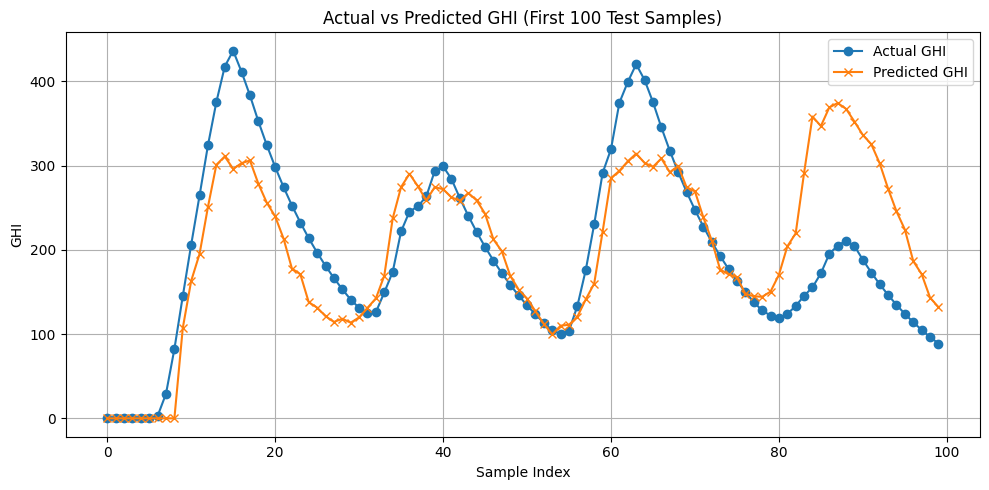

In [ ]:
results = train_and_predict_xgboost(train_data, test_data)

#### Custom MAPE Evaluation Logic: To accurately evaluate model performance, a custom MAPE formula was used to handle cases where actual GHI = 0

###### 1. If y_true ≠ 0:

$$
\text{APE} = \left| \frac{y_{\text{true}} - y_{\text{pred}}}{y_{\text{true}}} \right| \times 100
$$

###### 2. If y_true = 0 then:
###### - If y_pred = 0, APE = 0
###### - If y_pred ≠ 0: APE = 100


This avoids division-by-zero issues and penalizes unrealistic predictions during no-sunlight periods. The final MAPE is the mean of all such APE values.

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
# Computes the absolute percentage error (APE) element wise, handles division by zero for true values.
    return np.abs((y_true - y_pred) / y_true) * 100 if y_true != 0 else (100 if y_pred != 0 else 0)

# Compute APE values
ape_values = [mean_absolute_percentage_error(y_t, y_p) for y_t, y_p in zip(results['Actual_GHI'], results['Predicted_GHI'])]

# Compute Mean Absolute Percentage Error (MAPE)
mape_result = np.mean(ape_values)
print(f"MAPE Evaluation: {mape_result:.2f}%")

MAPE Evaluation: 20.89%


In [ ]:
# Add proper timestamp column to results if not present
results['timestamp'] = original_test_data.loc[results.index, 'timestamp']

# Extract month in YYYY-MM format
results['Month'] = pd.to_datetime(results['timestamp']).dt.to_period('M').astype(str)

# Compute MAPE grouped by formatted Month
monthly_mape = results.groupby('Month').apply(
    lambda g: np.mean([mean_absolute_percentage_error(y_t, y_p)
                       for y_t, y_p in zip(g['Actual_GHI'], g['Predicted_GHI'])])
)

# Create clean DataFrame for tabular output
monthly_mape_df = pd.DataFrame({
    'Month': monthly_mape.index,
    'avg_mape_for_ghi': monthly_mape.round(2).values
})

# Print tabular format exactly like requested
print(monthly_mape_df.to_string(index=False))

  Month  avg_mape_for_ghi
2025-01             15.13
2025-02             27.64


/tmp/ipython-input-73-3491757383.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_mape = results.groupby('Month').apply(


In [ ]:
results['timestamp'] = original_test_data.loc[results.index, 'timestamp']
results['mape'] = [
    mean_absolute_percentage_error(y_t, y_p)
    for y_t, y_p in zip(results['Actual_GHI'], results['Predicted_GHI'])
]

results['Month'] = pd.to_datetime(results['timestamp']).dt.to_period('M').astype(str)
monthly_mape = results.groupby('Month')['mape'].mean().round(2).reset_index()
monthly_mape.columns = ['timestamp', 'avg_mape_for_ghi']

final_df = pd.concat([
    results[['timestamp', 'Predicted_GHI', 'Actual_GHI', 'mape']].rename(
        columns={'Predicted_GHI': 'predicted_ghi', 'Actual_GHI': 'actual_ghi'}
    ),
    pd.DataFrame([[]]),
    monthly_mape
])

final_df.to_csv('/content/drive/MyDrive/Zelestra Assignment/Tanya_Sharan.csv', index=False)
print("Submission file 'Tanya_Sharan.csv' created successfully.")

Submission file 'Tanya_Sharan.csv' created successfully.


In [ ]:
%%writefile requirements.txt
pandas
numpy
matplotlib
seaborn
scikit-learn
xgboost

Writing requirements.txt


In [ ]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>